# Differential drive robot (i.e., "segbot") in artificial gravity

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import sympy as sym
from scipy import linalg
from scipy import signal

# Plotting libraries and settings
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams['font.serif'] = "Palatino"
plt.rcParams['font.family'] = "serif"

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the "latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_segbot)

pybullet build time: Jan 28 2022 20:18:15


<module 'ae353_segbot' from '/Users/patrickthornton/Desktop/ae353 - Design Projects/DP2 - segbot/ae353-DP2-segbot/ae353_segbot.py'>

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `width` and `height` (positive integers, default `640` and `480`, respectively) is the weight and height of the simulation window (if shown) in pixels;
* `bumpy` (`True` or `False`) is whether or not the station is "bumpy".

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [2]:
simulator = ae353_segbot.Simulator(
    display=False,
    width=480,
    height=320,
    bumpy=True,
)

## Compute full equations of motion and construct $f$

In [3]:
### Define physical constants, consistent with the URDF file:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Station parameters
station_velocity = -0.5 # <-- FIXME (change the velocity to change gravity)
station_radius = 20.    # <-- radius in meters of inside surface of station

# Acceleration of artifical gravity
g = station_velocity**2 * station_radius

### Convert all physical constants to rational numbers:
# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

### Define variables
(e_l, e_h, v, w, theta, thetadot, phi, phidot, tau_R, tau_L) = sym.symbols('e_l, e_h, v, w, theta, thetadot, phi, phidot, tau_R, tau_L', real=True)

### Compute equations of motion, excluding lateral and heading errors (see Tuttle, 2014):
M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + phi**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * phi - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
f = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))

### Compute full equations of motion (define right side of ODEs):
f = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [f]])

### Replace second-order ODE with two first-order ODEs
f = f.row_insert(4, sym.Matrix([[phi]]))

### Convert floating-point to rational numbers
f = sym.nsimplify(f, rational=True)
f

Matrix([
[                                                                                                                                                                      v*sin(e_h)],
[                                                                                                                                                                               w],
[        -(1200*tau_L + 1200*tau_R + 1404*(phi**2 + w**2)*sin(theta) + 65*(50*tau_L + 50*tau_R - 39*w**2*sin(2*theta) - 900*sin(theta))*cos(theta)/2)/(5850*cos(theta)**2 - 6084)],
[                                                                    32*(-1443*phi*w*sin(2*theta) - 875*tau_L + 875*tau_R - 2925*v*w*sin(theta))/(13*(3120*sin(theta)**2 + 2051))],
[                                                                                                                                                                             phi],
[5*(4225*tau_L + 4225*tau_R - 6591*w**2*sin(2*theta)/2 + 30*(100*tau_L + 100*tau_R + 117*(p

## Define a function to return a state-space model for a given choice of equilibrium point.

In [4]:
def get_model(
    e_l_e,
    e_h_e,
    v_e,
    w_e,
    theta_e,
    phi_e,
    tau_R_e,
    tau_L_e
):
    
    # Find A and B in symbolic form
    A_sym = f.jacobian([e_l, e_h, v, w, theta, phi])
    
    B_sym = f.jacobian([tau_R, tau_L])
    
    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([e_l, e_h, v, w, theta, phi, tau_R, tau_L], A_sym)
    
    B_num = sym.lambdify([e_l, e_h, v, w, theta, phi, tau_R, tau_L], B_sym)
    
    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(e_l_e, e_h_e, v_e, w_e, theta_e, phi_e, tau_R_e, tau_L_e).astype(float)
    
    B = B_num(e_l_e, e_h_e, v_e, w_e, theta_e, phi_e, tau_R_e, tau_L_e).astype(float)
    
    # Return A and B
    return A, B

## Define a controller that implements linear state feedback

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the gimbal. Modify the `run` function to make the controller behave differently.

In [5]:
class Controller:
    def __init__(
                 self,
                 K,
                 e_l_e,
                 e_h_e,
                 v_e,
                 w_e,
                 theta_e,
                 phi_e,
                 tau_R_e,
                 tau_L_e
        ):
        
        self.K = K
        self.e_l_e = e_l_e
        self.e_h_e = e_h_e
        self.v_e = v_e
        self.w_e = w_e
        self.theta_e = theta_e
        self.phi_e = phi_e
        self.tau_R_e = tau_R_e
        self.tau_L_e = tau_L_e
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        # Find state, x
        x = np.array([
            lateral_error - self.e_l_e,
            heading_error - self.e_h_e,
            forward_speed - self.v_e,
            turning_rate - self.w_e,
            pitch_angle - self.theta_e,
            pitch_rate - self.phi_e
        ])
        
        # Find input, u
        u = - self.K @ x
        
        # Find actuator command
        # FIXME: replace the following lines
        right_wheel_torque = u[0]
        left_wheel_torque = u[1]
        
        return right_wheel_torque, left_wheel_torque

## Define a function to get data from simulation for a given choice of equilibrium point, gain matrix, and initial condition.

In [6]:
def get_data(
    simulator, 
    e_l_e,
    e_h_e,
    v_e,
    w_e,
    theta_e,
    phi_e,
    tau_R_e,
    tau_L_e,
    K,
    v_i, 
    e_l_i, 
    e_h_i, 
    theta_i, 
    sv_i,
    max_time=5.0
):
    
    # Create controller
    controller = Controller(
        K,
        e_l_e,
        e_h_e,
        v_e,
        w_e,
        theta_e,
        phi_e,
        tau_R_e,
        tau_L_e
    )

    # Reset simulator with initial conditions [v_i, e_l_i, e_h_i, theta_i, sv_i]
    simulator.reset(
        initial_speed=v_i, # 1.
        initial_lateral_error=e_l_i, # 0.
        initial_heading_error=e_h_i, # 0.
        initial_pitch=theta_i, # 0.
        station_velocity=sv_i # -0.5
    )


    # Reset controller
    controller.reset()
    
    # Choose a camera view: [ camera_sideview(), camera_backview(), camera_wideview() ]
    simulator.camera_sideview()

    # Run simulator
    data = simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=max_time,    # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    )

    # Return data
    return data

## Define and verify equilibrium point

In [7]:
e_l_e = 0
e_h_e = 0
w_e = 0
theta_e = 0
phi_e = 0
tau_R_e = 0
tau_L_e = 0
v_e = 1

f_num = sym.lambdify([e_l, e_h, w, theta, phi, tau_R, tau_L], f)
f_eq = f_num(e_l_e, e_h_e, w_e, theta_e, phi_e, tau_R_e, tau_L_e)

# Convert numerical array from type 'object' to floats
f_eq = np.array(f_eq).astype(np.float64)

# Check
if not np.allclose(f_eq, 0.):
    raise Exception('equilibrium point is invalid')

## Get A and B matrices corresponding with chosen equilibrium point

In [8]:
A, B = get_model(
    e_l_e,
    e_h_e,
    v_e,
    w_e,
    theta_e,
    phi_e,
    tau_R_e,
    tau_L_e
)
print(A)
print(B)

[[   0.            1.            0.            0.            0.
     0.        ]
 [   0.            0.            0.            1.            0.
     0.        ]
 [   0.            0.            0.            0.         -125.
    -0.        ]
 [   0.            0.            0.            0.            0.
     0.        ]
 [   0.            0.            0.            0.            0.
     1.        ]
 [   0.            0.            0.           -0.          541.66666667
    -0.        ]]
[[  0.           0.        ]
 [  0.           0.        ]
 [ 12.07264957  12.07264957]
 [  1.05014439  -1.05014439]
 [  0.           0.        ]
 [-51.46011396 -51.46011396]]


## Determine a gains matrix that reliably and quickly stabilizes the system with linear state feedback (place poles method)

In [9]:
A, B = get_model(
    e_l_e,
    e_h_e,
    v_e,
    w_e,
    theta_e,
    phi_e,
    tau_R_e,
    tau_L_e
)

# DETERMINE MATRIX FOR LINEAR STATE FEEDBACK BY ADJUSTING POLES
p = np.array([-6., -5., -4., -3., -2., -1.])
fsf = signal.place_poles(A, B, p)
K = fsf.gain_matrix
print('K =',K)

K = [[  7.16211428  10.96649567  -0.51633179   4.28762377  -6.09242301
   -0.29684493]
 [ -7.14853392 -10.95641227   0.06734237  -4.28604627  -5.28811477
   -0.04160944]]


## Determine a gains matrix that reliably and quickly stabilizes the system with linear state feedback (LQR method)

In [37]:
# get A & B
A, B = get_model(
    e_l_e,
    e_h_e,
    v_e,
    w_e,
    theta_e,
    phi_e,
    tau_R_e,
    tau_L_e
)

# define weights
Q = np.eye(6)
R = np.eye(2)

# find optimal cost matrix
P = linalg.solve_continuous_are(A, B, Q, R)

# find optimal gain matrix
K = linalg.inv(R) @  B.T @ P
print('K = \n',K)

# check that eigenvalues have negative real part
print('\neigenvalues:\n', linalg.eigvals(A - B @ K))

K = 
 [[  0.70710678   3.37703351  -0.70710678   1.9276359  -10.84946636
   -1.0251626 ]
 [ -0.70710678  -3.37703351  -0.70710678  -1.9276359  -10.84946636
   -1.0251626 ]]

eigenvalues:
 [ -1.98233049+0.j          -1.03313079+1.38901874j
  -1.03313079-1.38901874j -81.39566698+0.j
  -6.76667351+0.j          -0.27432326+0.j        ]


## Generate contour plot of final simulator data for various Q and R

Text(0.5, 1.0, 'Final Pitch Angle as a Function of Q and R Weights ($v_e = 4$)')

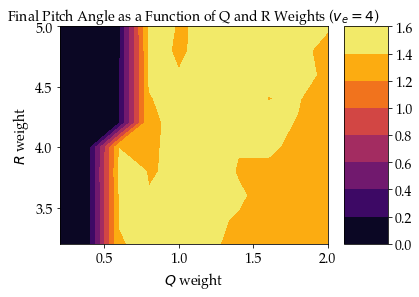

In [41]:
# define equilibrium point
e_l_e   = 0
e_h_e   = 0
w_e     = 0
theta_e = 0
phi_e   = 0
tau_R_e = 0
tau_L_e = 0
v_e     = 4 # <-- ADJUSTABLE

# define initial conditions
v_i     = 1.    # initial_speed (1.)
e_l_i   = 0.    # initial_lateral_error (0.)
e_h_i   = 0.    # initial_heading_error (0.)
theta_i = 0.    # initial_pitch (0.)
sv_i    = -0.5  # station_velocity(-0.5)

# get A and B
A, B = get_model(
    e_l_e,
    e_h_e,
    v_e,
    w_e,
    theta_e,
    phi_e,
    tau_R_e,
    tau_L_e
)

# define identity matrices with appropriate sizes
Q_I = np.eye(6)
R_I = np.eye(2)

# set range of Q and R weights
step = 0.2 # spacing between values
Q = np.arange(0. + step, 2. + step, step)
R = np.arange(3. + step, 5. + step, step)
Q, R = np.meshgrid(Q, R)

# initialize matrix to store resulting data
z = np.zeros((Q.shape[0], R.shape[0]))

# get data for each Q and R weights
for i in range(Q.shape[0]):
    for j in range(Q.shape[0]):
        
        # find optimal cost matrix
        P = linalg.solve_continuous_are(A, B, Q[i,j]*Q_I, R[i,j]*R_I)
        
        # find optimal gain matrix
        K = linalg.inv(R[i,j]*R_I) @  B.T @ P
        
        # generate data
        data = get_data(
            simulator, 
            e_l_e,
            e_h_e,
            v_e,
            w_e,
            theta_e,
            phi_e,
            tau_R_e,
            tau_L_e,
            K,
            v_i, 
            e_l_i, 
            e_h_i, 
            theta_i, 
            sv_i,
            max_time=5.0
        )
        
        # store data for each combination of Q and R
        z[i, j] = data['pitch_angle'][-1]
        
fig, ax = plt.subplots()

# surf = plt.contourf(Q, R, z, 200, cmap=cm.inferno)
surf = plt.contourf(Q, R, z, cmap=cm.inferno)

cbar = fig.colorbar(surf, shrink=1, aspect=5)
cbar.ax.tick_params(labelsize=14) 

ax.set_xlabel( '$Q$ weight', fontsize= 14)
ax.set_ylabel( '$R$ weight', fontsize= 14)

ax.tick_params(labelsize=14)

ax.set_title( 'Final Pitch Angle as a Function of Q and R Weights ($v_e = 4$)', fontsize=14)

## Show results for a particular choice of equilibrium point, gain matrix, and initial conditions

In [11]:
# define equilibrium point
e_l_e   = 0
e_h_e   = 0
w_e     = 0
theta_e = 0
phi_e   = 0
tau_R_e = 0
tau_L_e = 0
v_e     = 1 # <-- ADJUSTABLE

# define initial conditions
v_i     = 1.    # initial_speed (1.)
e_l_i   = 0.    # initial_lateral_error (0.)
e_h_i   = 0.    # initial_heading_error (0.)
theta_i = 0.    # initial_pitch (0.)
sv_i    = -0.5  # station_velocity(-0.5)

# get A and B matrices
A, B = get_model(
    e_l_e,
    e_h_e,
    v_e,
    w_e,
    theta_e,
    phi_e,
    tau_R_e,
    tau_L_e
)

# define K matrix for linear state feedback
# define weights
Q = np.eye(6)
R = np.eye(2)
# find optimal cost matrix
P = linalg.solve_continuous_are(A, B, Q, R)
# find optimal gain matrix
K = linalg.inv(R) @  B.T @ P

# get simulator data for chosen equilibrium point and initial conditions
data = get_data(
    simulator, 
    e_l_e,
    e_h_e,
    v_e,
    w_e,
    theta_e,
    phi_e,
    tau_R_e,
    tau_L_e,
    K,
    v_i, 
    e_l_i, 
    e_h_i, 
    theta_i, 
    sv_i,
    max_time=5.0
)

Get, show, and save a snapshot of the simulation after the last time step.

In [ ]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

In [ ]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [ ]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)